In [1]:
%%javascript
MathJax.Hub.Config({
    TeX: { equationNumbers: { autoNumber: "AMS" } }
});
// Code to be able to number equations in the markdown

<IPython.core.display.Javascript object>

In [3]:
import numpy as np
import matplotlib.pyplot as plt
# import matplotlib.animation as animation
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

## Explicit finite difference scheme

### Rewriting equation in terms of row (position) and column (time) indicies.

The equation (Eq. 4.0 in doc) given to me by Jack is: 

\begin{equation}
E^{n+1}_i = \left ( \frac{\Delta t}{\Delta x} \frac{c}{n} \right )^2 (E^{n}_{i+1} - 2E^{n}_{i} + E^{n}_{i-1})-(-2E^{n}_{i} + E^{n-1}_{i})
\end{equation}

where $ \displaystyle r = \left ( \frac{\Delta t}{\Delta x} \frac{c}{n} \right )^2 $ and n is the position index and i is the time index (dimensionless)

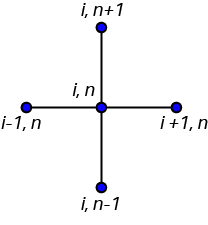

Using the image above, we use [i,n] ; [i-1,n] ; [i+1,n] ; [i, n-1] and take a weighted average to find [i,n+1].

### Defining global arrays for I, E, T_e, T_i, n_e, rho


In [4]:
I = np.zeros((10, 10))
E = np.zeros((10, 10))
T_e = np.zeros((10, 10))
T_i = np.zeros((10, 10))
n_e = np.zeros((10, 10))
rho = np.zeros((10, 10))

### Defining parameters needed to solve differential equation: $ \nabla^{2} E - \frac{n^2}{c^2} \frac{\partial^2 E}{\partial t^{2}} = 0$

In [5]:
# Unit conversions
ps = 10**-12    # picoseconds unit
nm = 10**-9     # nanometers unit
um = 10 ** -6   # micrometer unit
    
# Physical parameters
RefractiveIndex = 1                         # unitless
speed_of_light = 299792458                  # in m/s
wavelength = 351 * nm # we choose wavelength

# time-step size “dt” is strictly controlled by Courant–Friedrichs–Lewy (CFL) condition 
#so that the wave propagation distance within a allowed time-step size cannot exceed the grid size “dx”.
CFL = 0.1
delta_x = 0.01 * wavelength
delta_t = CFL * delta_x / speed_of_light    # time related time-step

# Physics formulas
frequency = speed_of_light/wavelength       # in Hertz
angular_frequency = 2 * np.pi * frequency   # in Hertz
wavenumber = (2 * np.pi) / wavelength       # wave number 'k' will be imaginary part in the coming days (when we do it correctly)
period = wavelength / speed_of_light        # wave period (can also be calculated with 1/f)

# Grid and time parameters
T = 1 * ps              # time in seconds (* picoseonds) (in the future, will represent modeling time)
n_timestep = 1000        # n time step
n_cycles = period / delta_t  # number of timesteps to finish one period
ntimestep_dividedby_ncycle = n_timestep / n_cycles # equal to number of periods passing through simulation time 
L = 500 * nm            # length in SI units in meters
n_cells = 10            # number of cells (can also think of as number of grid points)
# delta_x = L/n_cells     # spatial time-step (can also think of as grid spacing)



### Initializing laser intensity and electric field

In [6]:
R = 25 * um # radius of laser
E_L = 10 * (10 ** -6) # in joules laser energy (10 mu joules)
Area_L = np.pi * R **2 # area of laser
T_laser = 100 * ps # laser pulse time
I_0 = E_L / (Area_L * T_laser) # laser intensities (SI unit is Joules/(m**2) * s )
permittivity_free_space = 8.85418782 * 10 **-12

# Electric field
E_0 = np.sqrt( (2 * I_0) / (speed_of_light * RefractiveIndex * permittivity_free_space) ) # SI unit is voltage / m

# Laser intensity
I_0 = E_L / (Area_L * T_laser) # laser intensities (SI unit is Joules/(m**2) * s )

### Solving explicitly using Eq (1): $E^{n+1}_i = \left ( \frac{\Delta t}{\Delta x} \frac{c}{n} \right )^2 (E^{n}_{i+1} - 2E^{n}_{i} + E^{n}_{i-1})-(-2E^{n}_{i} + E^{n-1}_{i})$

In [10]:
x = []  # spatial domain (can also think of as coordinates of grid points)
t = []  # time domain

# Creating arrays for the spatial and time domains. Starting at -2 in order to create ghost cells. And ending with + 3 for the same reason
# The ghost cells are there so that in the matrix we can access all indeces
# To append, using formula Dr. Woo gave me: X_i = delta_x(i + 1/2)
for i in range(-2, n_cells + 3):
    x.append(delta_x * (i + 0.5))

for i in range(-2, n_timestep + 3):
    t.append(delta_t * (i + 0.5))
    
x = np.array(x)
t = np.array(t)

# BEFORE: E = np.zeros((len(x), len(t)))
E = np.zeros((len(t), len(x)))

r_const = ( (delta_t/delta_x) * (speed_of_light/RefractiveIndex) ) ** 2 # our parameter

# These loops will go through the grid. We start at 1 so as to not calculate the
# value when the a time or spatial point is equal to 0.
index = 0
for n in range(1, (len(t) - 3)*1 + 0):
    t_sim = t[n] # in seconds
    
    # Initial conditions in time:
    E[n-1, 0] = E_0 * np.sin( angular_frequency * t[n-1] - wavenumber * x[0] )
    E[n-1, 1] = E_0 * np.sin( angular_frequency * t[n-1] - wavenumber * x[1] )
    
    # Instantenously defining the boundary conditions/values of ghost cells on the RIGHT:
    E[n, 0] = E_0 * np.sin( angular_frequency * t[n] - wavenumber * x[0] )
    E[n, 1] = E_0 * np.sin( angular_frequency * t[n] - wavenumber * x[1] )
    
    # We have no laser on the left, so boundary conditions are just 0
    E[n, -1] = 0
    E[n, -2] = 0
    
    # Initial conditions in time:
    E[1, 2:] = 0
    for i in range(2, len(x) - 3):
        E[n+1, i] = (r_const) * ( E[n, i+1] - 2*E[n, i] + E[n, i-1] ) - ( -2*E[n, i] + E[n-1, i] )
        
#         print('E[n+1, i]/E_0', E[n+1, i]/E_0)
        
        # if the ratio is not bounded to from -1 to 1, then we have overshot and are out of simulation physical bounds
        if abs(E[n+1, i]/E_0) > 1:
            print('stop')
            print('index', index, 'n+1', n+1, 'i', i, 'E[n+1, i]', E[n+1, i], 'E[n+1, i]/E_0', E[n+1, i]/E_0, (r_const) * (E[n, i+1] - 2*E[n, i] + E[n, i-1]), -2*E[n, i] + E[n-1, i], E[n, i-1] * r_const)
            break
    
        index += 1

## Modeling the damping wave

In [13]:
n_r = 0.85
n_i = 6.48
complex_refractive_index = complex(n_r, n_i)

In [6]:
R = 25 * um # radius of laser
E_L = 10 * (10 ** -6) # in joules laser energy (10 mu joules)
Area_L = np.pi * R **2 # area of laser
T_laser = 100 * ps # laser pulse time
I_0 = E_L / (Area_L * T_laser) # laser intensities (SI unit is Joules/(m**2) * s )
permittivity_free_space = 8.85418782 * 10 **-12

# Electric field (same as before but now using complex refractive index)
E_0 = np.sqrt( (2 * I_0) / (speed_of_light * complex_refractive_index * permittivity_free_space) ) # SI unit is voltage / m

# Laser intensity
I_0 = E_L / (Area_L * T_laser) # laser intensities (SI unit is Joules/(m**2) * s )

In [12]:
x = []  # spatial domain (can also think of as coordinates of grid points)
t = []  # time domain

# Creating arrays for the spatial and time domains. Starting at -2 in order to create ghost cells. And ending with + 3 for the same reason
# The ghost cells are there so that in the matrix we can access all indeces
# To append, using formula Dr. Woo gave me: X_i = delta_x(i + 1/2)
for i in range(-2, n_cells + 3):
    x.append(delta_x * (i + 0.5))

for i in range(-2, n_timestep + 3):
    t.append(delta_t * (i + 0.5))
    
x = np.array(x)
t = np.array(t)

# BEFORE: E = np.zeros((len(x), len(t)))
E = np.zeros((len(t), len(x)))

r_const_complex = ( (delta_t/delta_x) * (speed_of_light/complex_refractive_index) ) ** 2 # our parameter

# These loops will go through the grid. We start at 1 so as to not calculate the
# value when the a time or spatial point is equal to 0.
index = 0
for n in range(1, (len(t) - 3)*1 + 0):
    t_sim = t[n] # in seconds
    
    cos_term_0 = E_0 * np.cos((wavenumber * x[0]) - (angular_frequency * t[n-1]))
    sin_term_0 = E_0 * np.sin((wavenumber * x[0]) - (angular_frequency * t[n-1]))
    
    cos_term_1 = E_0 * np.cos((wavenumber * x[1]) - (angular_frequency * t[n-1]))
    sin_term_1 = E_0 * np.sin((wavenumber * x[1]) - (angular_frequency * t[n-1]))
    
    # Initial conditions in time:
    
    E[n-1, 0] = E_0 * np.sin( angular_frequency * t[n-1] - wavenumber * x[0] )
    E[n-1, 1] = E_0 * np.sin( angular_frequency * t[n-1] - wavenumber * x[1] )
    
    # Instantenously defining the boundary conditions/values of ghost cells on the RIGHT:
    E[n, 0] = E_0 * np.sin( angular_frequency * t[n] - wavenumber * x[0] )
    E[n, 1] = E_0 * np.sin( angular_frequency * t[n] - wavenumber * x[1] )
    
    # We have no laser on the left, so boundary conditions are just 0
    E[n, -1] = 0
    E[n, -2] = 0
    
    # Initial conditions in time:
    E[1, 2:] = 0
    for i in range(2, len(x) - 3):
        E[n+1, i] = (r_const_complex) * ( E[n, i+1] - 2*E[n, i] + E[n, i-1] ) - ( -2*E[n, i] + E[n-1, i] )
        
#         print('E[n+1, i]/E_0', E[n+1, i]/E_0)
        
        # if the ratio is not bounded to from -1 to 1, then we have overshot and are out of simulation physical bounds
        if abs(E[n+1, i]/E_0) > 1:
            print('stop')
            print('index', index, 'n+1', n+1, 'i', i, 'E[n+1, i]', E[n+1, i], 'E[n+1, i]/E_0', E[n+1, i]/E_0, (r_const) * (E[n, i+1] - 2*E[n, i] + E[n, i-1]), -2*E[n, i] + E[n-1, i], E[n, i-1] * r_const)
            break
    
        index += 1

## Laser source

Plot an animated wave through time.

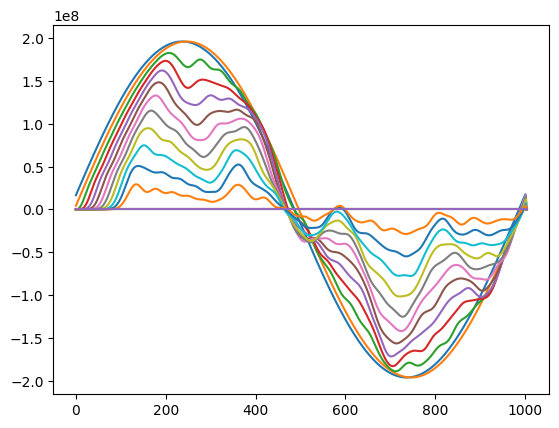

In [8]:
plt.plot(E)
plt.legend
plt.show()

In [ ]:
%matplotlib notebook

In [ ]:
Y_UPPER_LIMIT = 3 * 10**8
Y_LOWER_LIMIT = -3 * 10**8

In [ ]:
fig, ax = plt.subplots()
ax.set(xlim=(0, 100), ylim=(Y_LOWER_LIMIT, Y_UPPER_LIMIT))

line = ax.plot(x, E[:,0], color='k', lw=2)[0]

def animate(i):
    line.set_ydata(E[:,i])
    
anim = FuncAnimation(fig, animate, interval=1, frames=100)
 
anim.save('filename.gif')
    
# plt.draw()
plt.show()

In [ ]:
# initializing a figure in 
# which the graph will be plotted
fig = plt.figure() 
   
# marking the x-axis and y-axis
axis = plt.axes(xlim=(0, 100), ylim=(Y_LOWER_LIMIT, Y_UPPER_LIMIT)) 
  
# initializing a line variable
line, = axis.plot([], [], lw = 3) 

# data which the line will 
# contain (x, y)
def init(): 
    line.set_data([])
    return line,
   
def animate(i):
#     x = np.linspace(0, 4, 1000)
   
    # plots a sine graph
#     y = np.sin(2 * np.pi * (x - 0.01 * i))
    line.set_data(E[i])
      
    return line,
   
anim = FuncAnimation(fig, animate, init_func = init,
                     frames = 1, interval = 20, blit = True)
  
anim.save('test.gif')

plt.show()